# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
# Import TensorFlow 
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Ignore some warnings that are not relevant (you can remove this if you prefer)
import warnings
warnings.filterwarnings('ignore')

C:\Users\fisch\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# TODO: Make all other necessary imports.
# As we made it in chapter transfer learning 

import time
import matplotlib.pyplot as plt
import json

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
# Some other recommended settings:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.disable_progress_bar()

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [4]:
#TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load()
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised = True, with_info=True) # As it is described in https://www.tensorflow.org/datasets/api_docs/python/tfds/load


In [5]:
# TODO: Create a training set, a validation set and a test set.
dataset.keys()

dict_keys(['train', 'test', 'validation'])

In [6]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

In [7]:
train_data = dataset['train'] #read the different data
validation_data = dataset['validation']
test_data = dataset['test']

## Explore the Dataset

In [8]:
# TODO: Get the number of examples in each set from the dataset info.
train_data_len = dataset_info.splits ['train'].num_examples
validation_data_len = dataset_info.splits ['validation'].num_examples
test_data_len = dataset_info.splits ['test'].num_examples

print('train_data_len: {}, validation_data_len={}, test_data_len={}'.format(train_data_len,validation_data_len,test_data_len))
# TODO: Get the number of classes in the dataset from the dataset info.

number_of_classes = dataset_info.features ['label'].num_classes
print('number_of_classes: {}'.format(number_of_classes))

train_data_len: 1020, validation_data_len=1020, test_data_len=6149
number_of_classes: 102


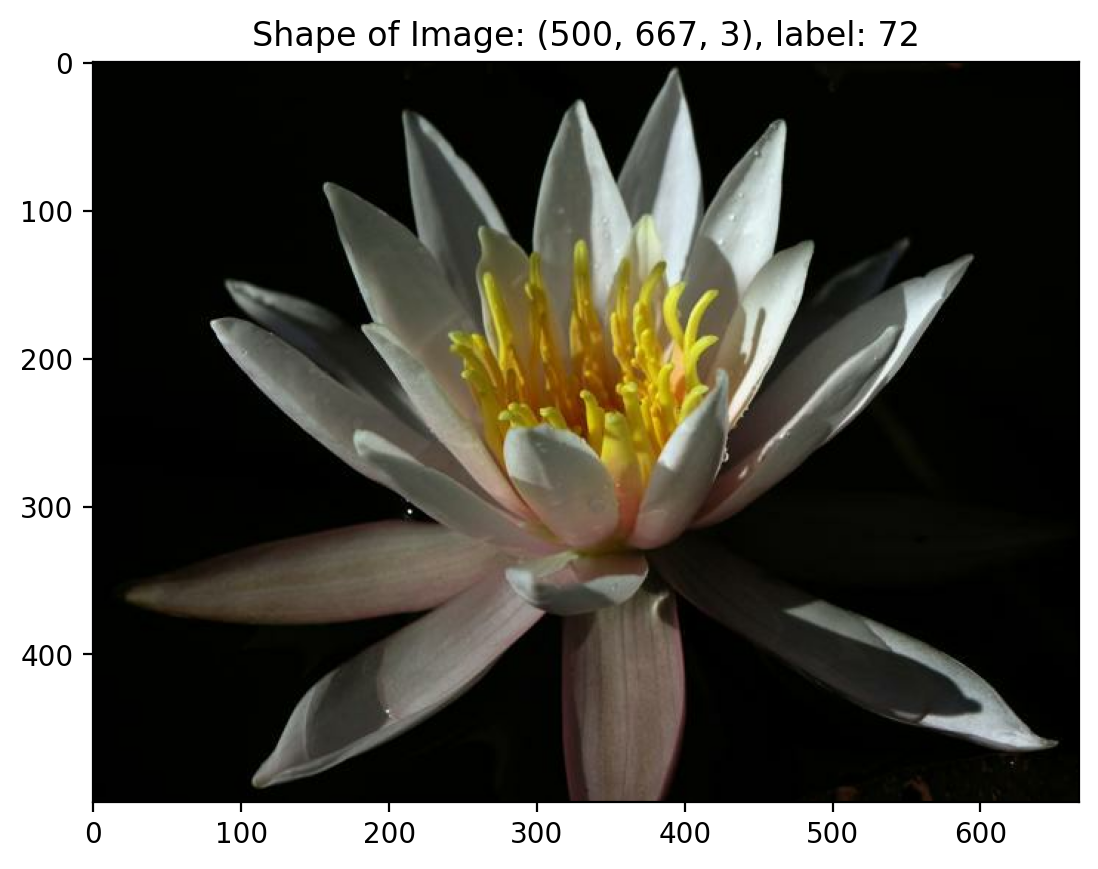

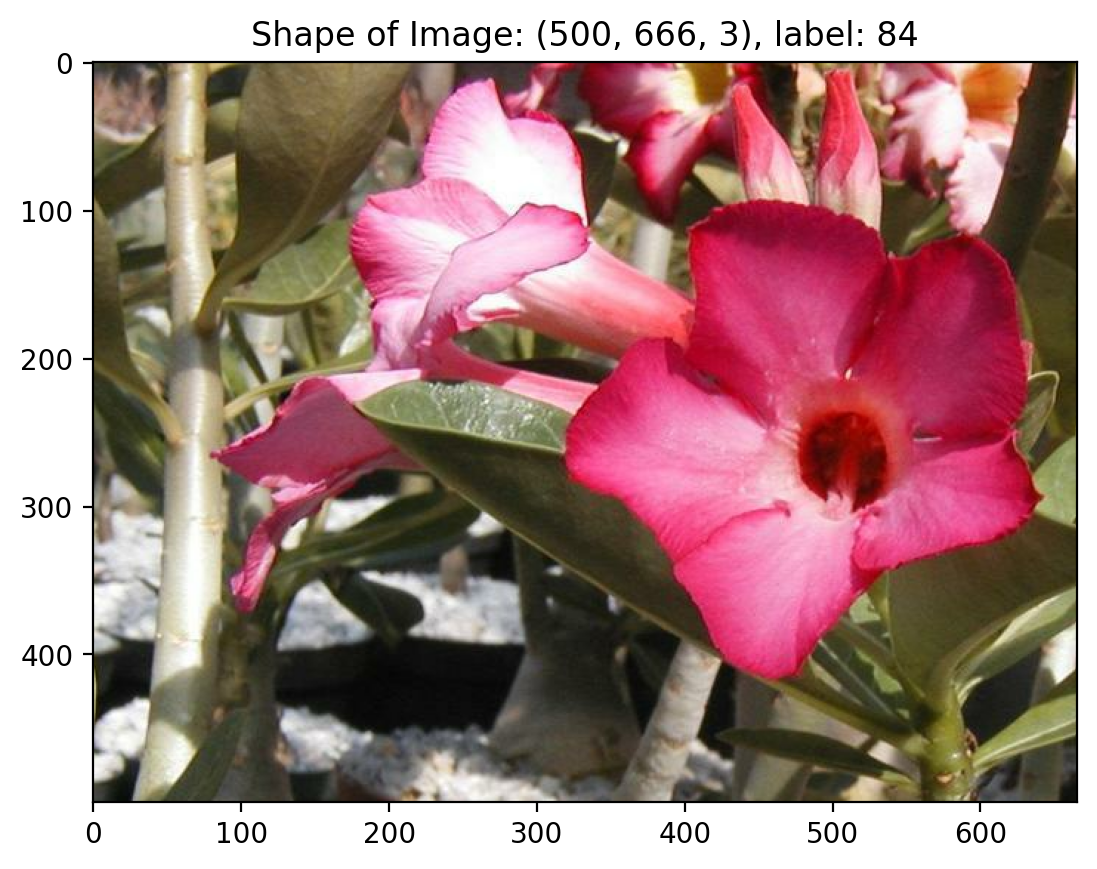

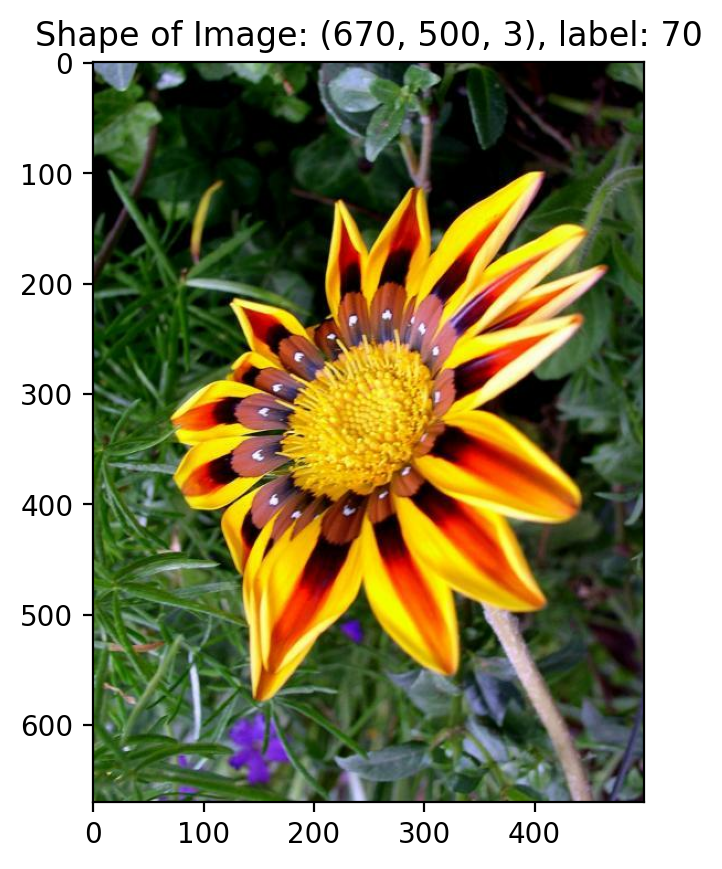

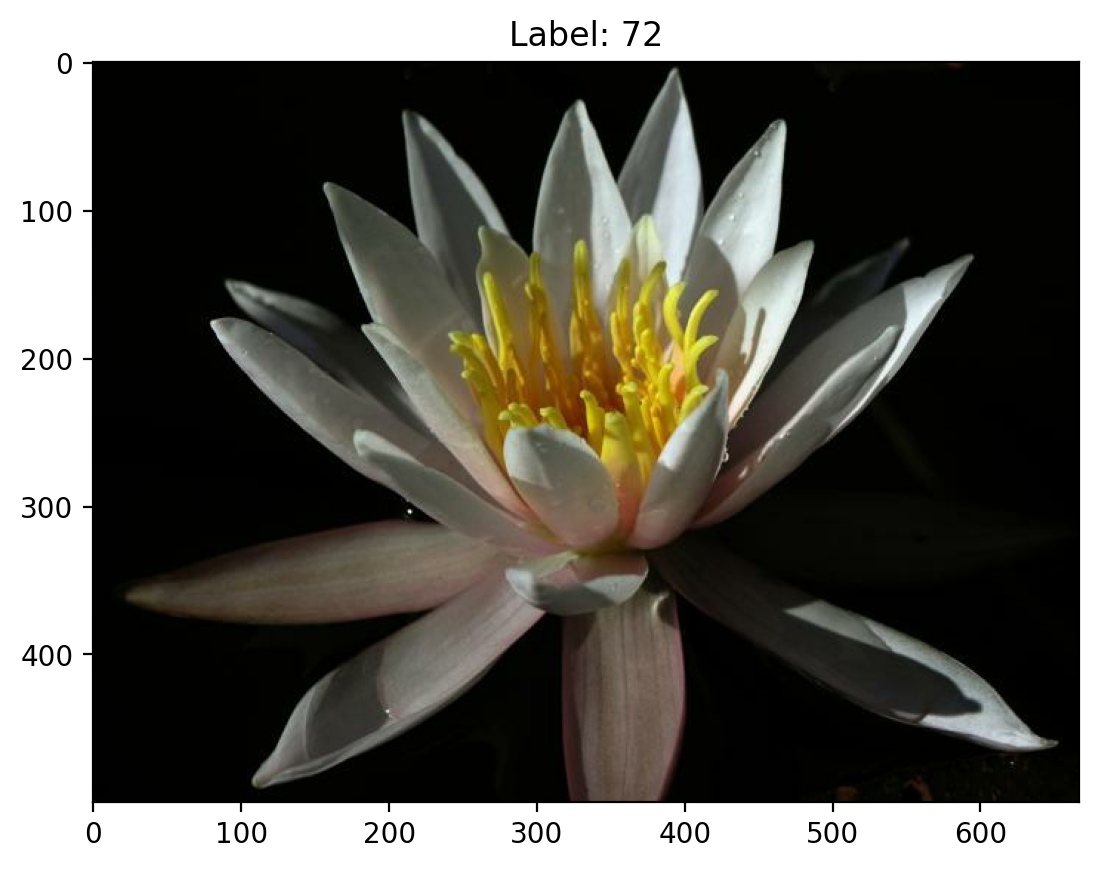

In [9]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in train_data.take(3):
    image = image.numpy()
    label = label.numpy()
    plt.imshow(image)
    plt.title('Shape of Image: {}, label: {}'.format(image.shape,label))
    plt.show()# TODO: Plot 1 image from the training set. Same as before only one image 
for image, label in train_data.take(1):
    image = image.numpy()
    label = label.numpy()
    plt.imshow(image)
    plt.title('Label: {}'.format(label))
    plt.show()
# Set the title of the plot to the corresponding image label. 

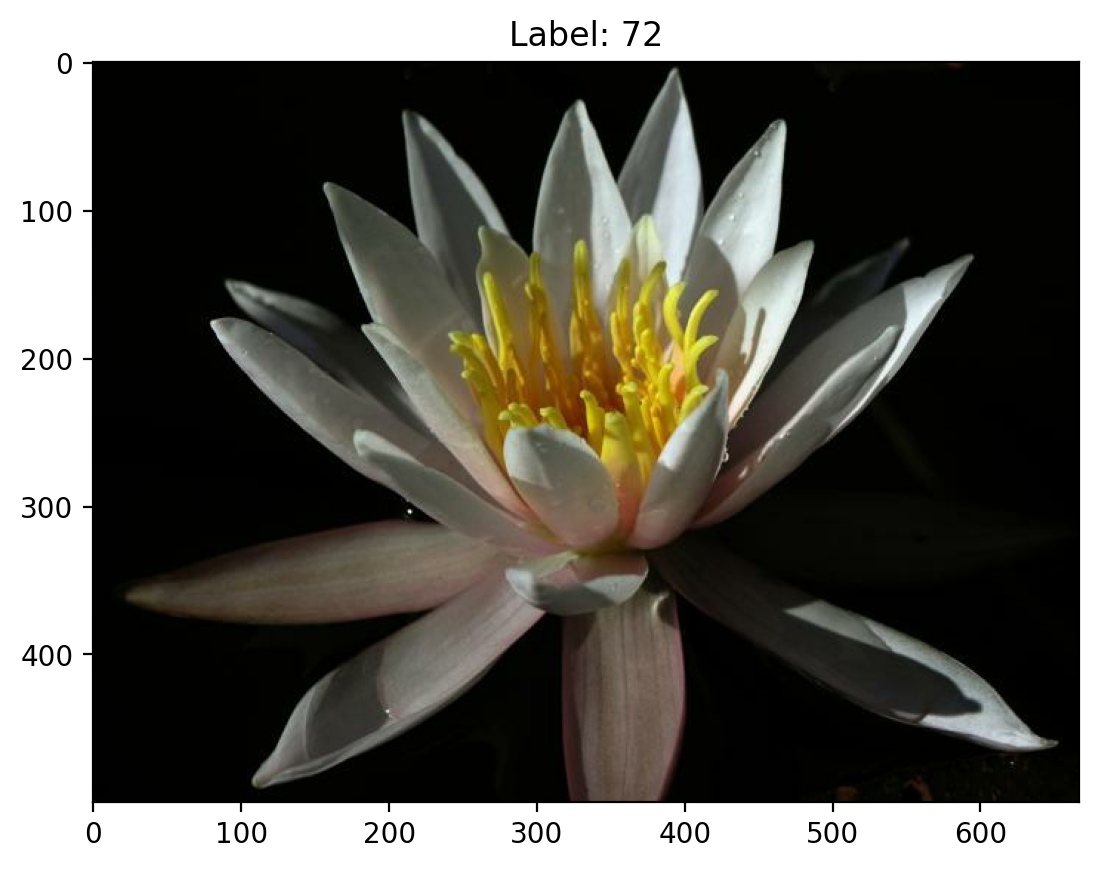

In [10]:
# TODO: Plot 1 image from the training set. Same as before only one image 
for image, label in train_data.take(1):
    image = image.numpy()
    label = label.numpy()
    plt.imshow(image)
    plt.title('Label: {}'.format(label))
    plt.show()
# Set the title of the plot to the corresponding image label. 

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [11]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [12]:
class_names

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [13]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 



## Create Pipeline

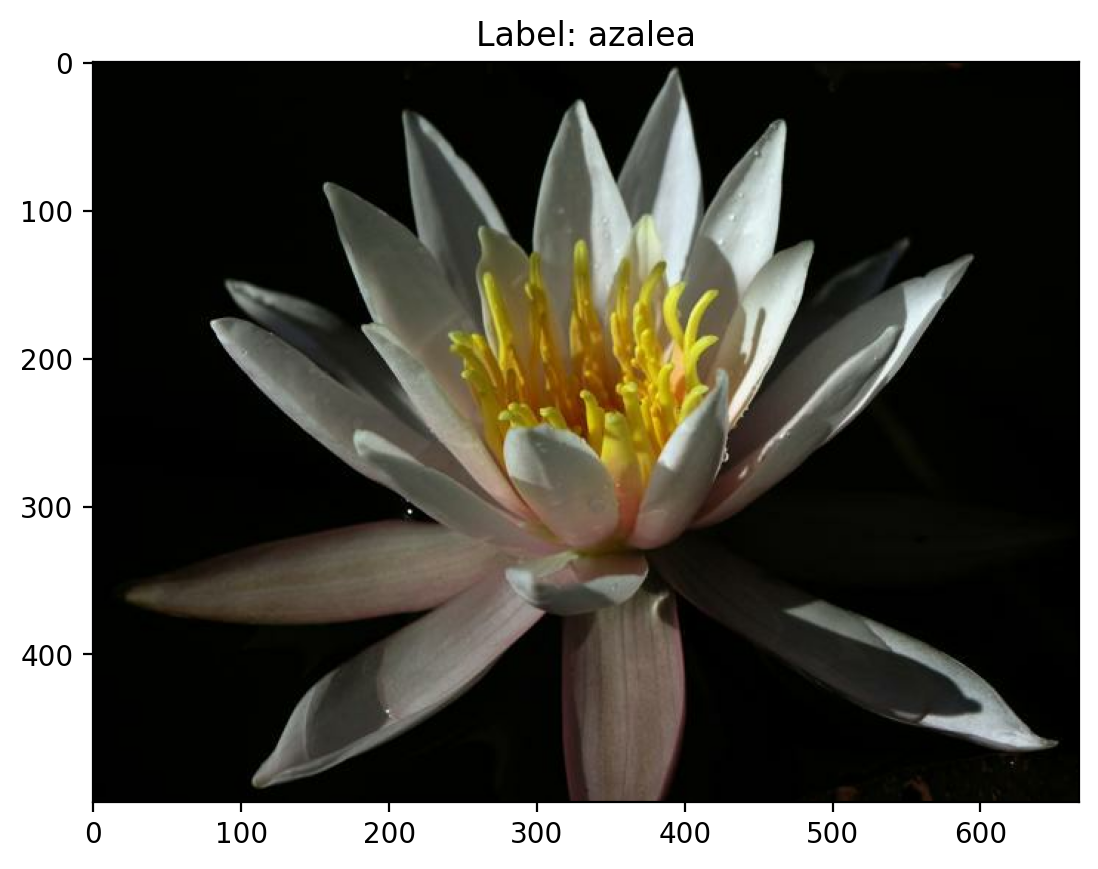

In [14]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

for image, label in train_data.take(1):
    image = image.numpy()
    label = label.numpy()
    plt.imshow(image)
    plt.title('Label: {}'.format(class_names[str(label)]))
    plt.show()


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [15]:
# TODO: Create a pipeline for each set.
# Like in the notebook tranfer_learning 
batch_size = 32
image_size = 224 # Because the pretrained networks need 224*224 pixels as input


def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image/255
    return image, label


training_batches = train_data.shuffle(train_data_len // 4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_data.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_data.map(format_image).batch(batch_size).prefetch(1)



In [16]:
different_model_accuracy = []

## Test and train your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well. 

# First attempt: Neuronal Network with 1 output dens layer -> Model ID 1 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2388646 (9.11 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Epoch 1/15
32/32 [==============================] - 40s 1s/step - loss: 4.2187 - accuracy: 0.1216 - val_loss: 3.0690 - val_accuracy: 0.4069
Epoch 2/15
32/32 [==============================] - 35s 1s/step - loss: 2.0495 - accuracy: 0.6922 - val_loss: 2.0123 - val_accuracy: 0.6500
Epoch 3/15
32/32 [==============================] - 35s 1s/step - loss: 1.0964 - accuracy: 0.8902 - val_loss: 1.5339 - val_accura

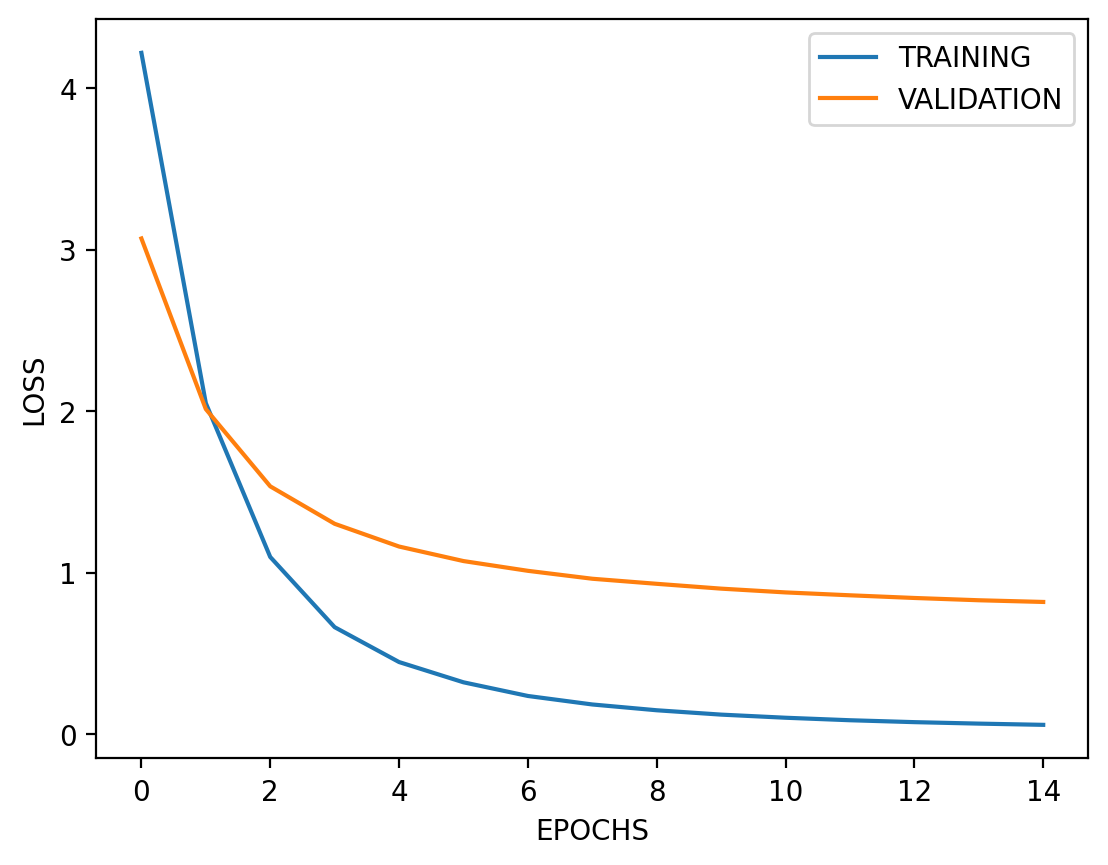

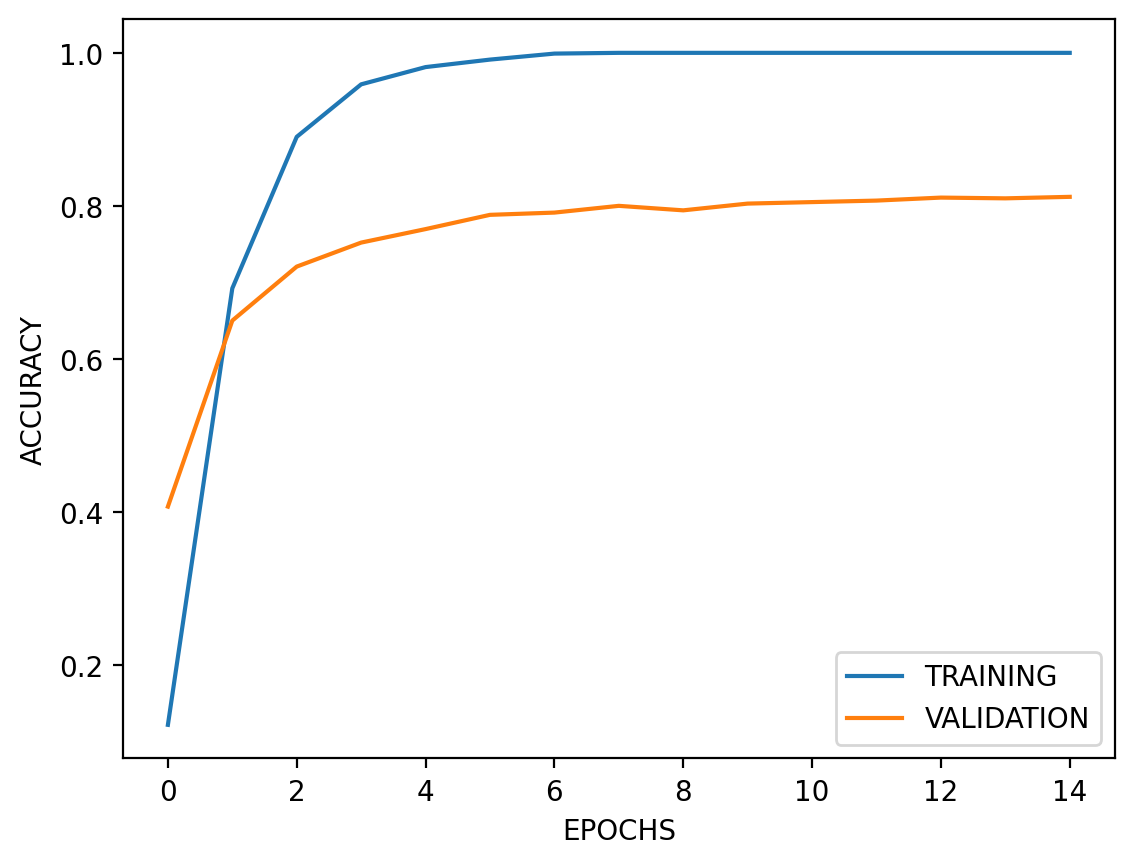

193/193 [==============================] - 124s 643ms/step - loss: 0.9486 - accuracy: 0.7694
test accuracy is: 0.7693933844566345


In [18]:
# TODO: Build and train your network.
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" # copied from pretrained notebook

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

feature_extractor.trainable = False # Parameter of the networks are frozen

model1 = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(number_of_classes, activation = 'softmax') # classifier with 2 layers in output
])

model1.summary()

model1.compile(optimizer='adam', #copied from last chapter
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 15

history = model1.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

plt.figure()
plt.plot(range(EPOCHS), history.history['loss'], label="TRAINING")
plt.plot(range(EPOCHS), history.history['val_loss'], label="VALIDATION")
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(EPOCHS), history.history['accuracy'], label="TRAINING")
plt.plot(range(EPOCHS), history.history['val_accuracy'], label="VALIDATION")
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.legend()
plt.show()

testloss, testaccuracy = model1.evaluate(testing_batches)
print('test accuracy is: {}'.format(testaccuracy)) 

different_model_accuracy.append(testaccuracy)

# Secound attempt: Neuronal Network with 1 hidden and 1 output dens layers -> Model ID 2 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_2 (Dense)             (None, 102)               104550    
                                                                 
Total params: 3674278 (14.02 MB)
Trainable params: 1416294 (5.40 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Epoch 1/15
32/32 [==============================] - 53s 1s/step - loss: 3.6917 - accuracy: 0.2529 - val_loss: 2.0902 - val_accuracy: 0.5725
Epoch 2/15
32/32 [==============================] - 44s 1s/step - loss: 0.9080 - accuracy: 0.8147 - val_loss: 1.2395 - val_accuracy: 0.

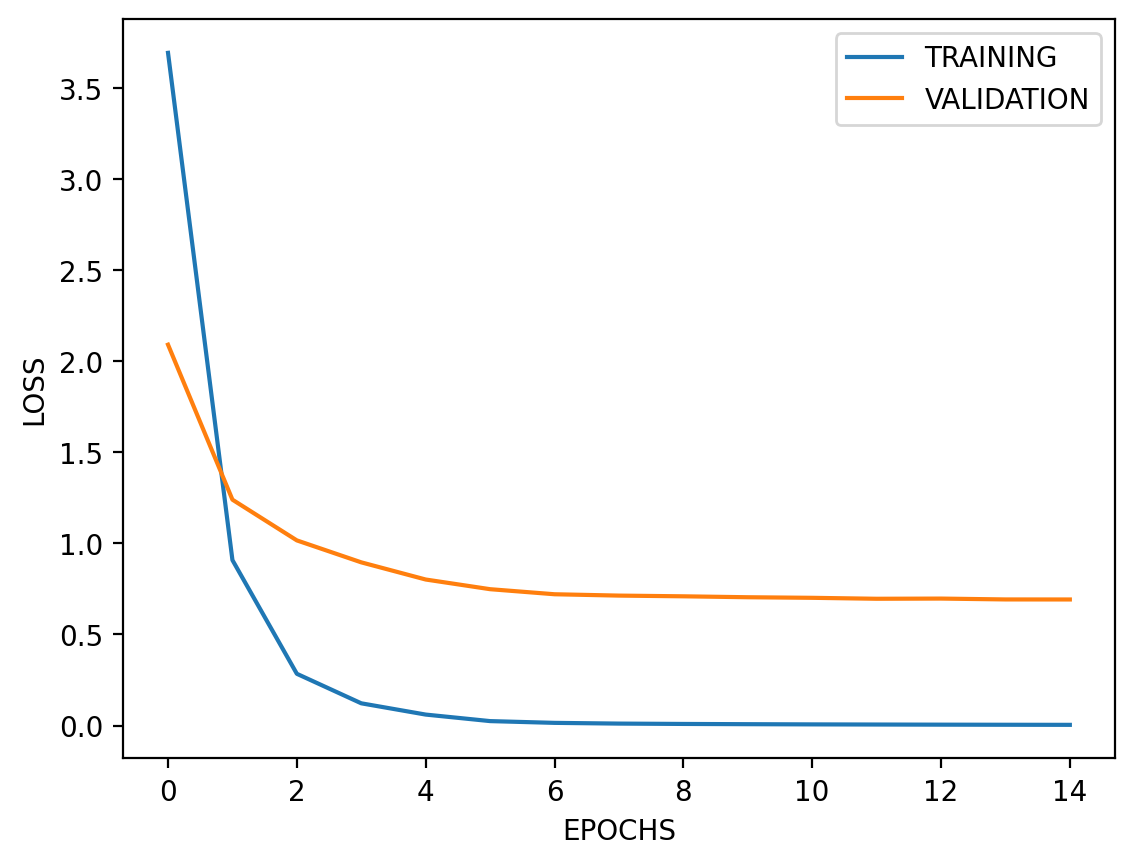

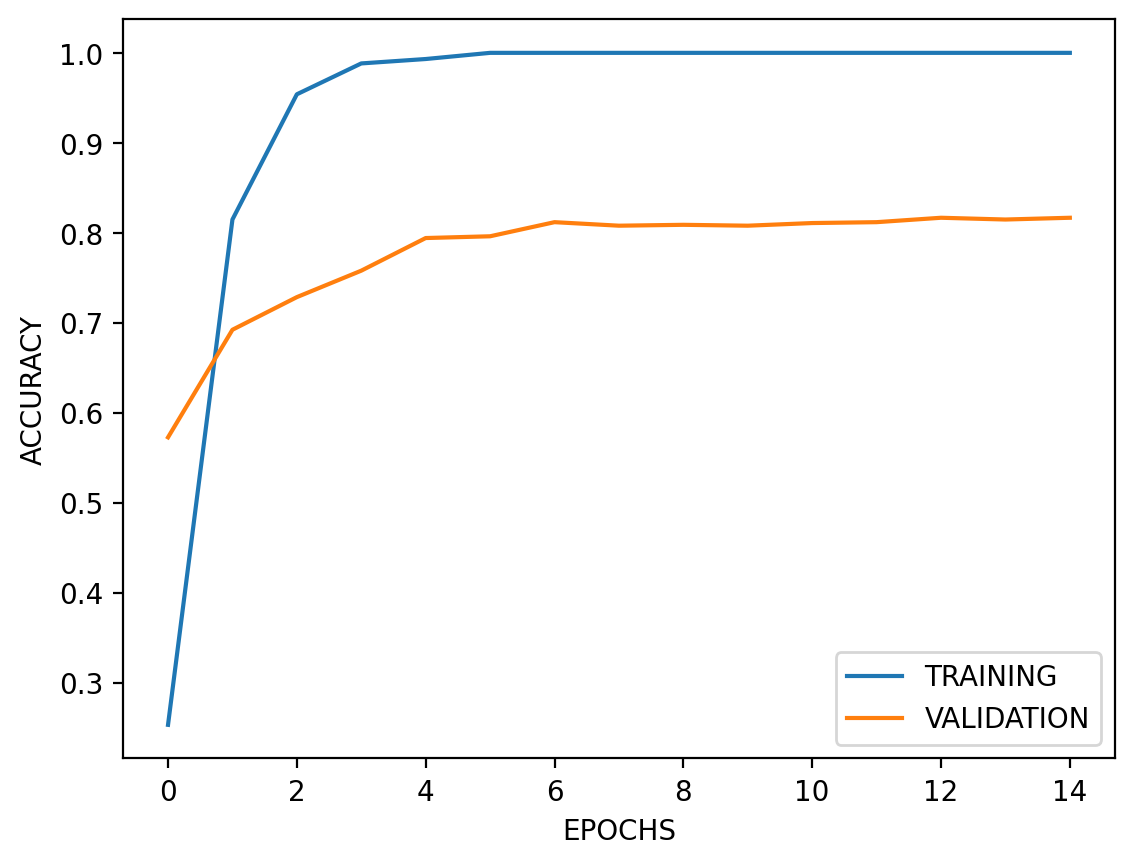

193/193 [==============================] - 109s 565ms/step - loss: 0.8429 - accuracy: 0.7835
test accuracy is: 0.7835420370101929


In [19]:
# TODO: Build and train your network.
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" # copied from pretrained notebook

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

feature_extractor.trainable = False # Parameter of the networks are frozen

model2 = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(1024, activation = 'relu'),
        tf.keras.layers.Dense(number_of_classes, activation = 'softmax') # classifier with 2 layers in output
])

model2.summary()

model2.compile(optimizer='adam', #copied from last chapter
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 15

history = model2.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

plt.figure()
plt.plot(range(EPOCHS), history.history['loss'], label="TRAINING")
plt.plot(range(EPOCHS), history.history['val_loss'], label="VALIDATION")
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(EPOCHS), history.history['accuracy'], label="TRAINING")
plt.plot(range(EPOCHS), history.history['val_accuracy'], label="VALIDATION")
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.legend()
plt.show()

testloss, testaccuracy = model2.evaluate(testing_batches)
print('test accuracy is: {}'.format(testaccuracy)) 

different_model_accuracy.append(testaccuracy)

# Thrid attempt: Neuronal Network with 1 hidden and one output dens layers with more weights -> Model ID 3

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_3 (Dense)             (None, 2048)              2623488   
                                                                 
 dense_4 (Dense)             (None, 102)               208998    
                                                                 
Total params: 5090470 (19.42 MB)
Trainable params: 2832486 (10.81 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Epoch 1/15
32/32 [==============================] - 39s 1s/step - loss: 3.5804 - accuracy: 0.2716 - val_loss: 1.8260 - val_accuracy: 0.5716
Epoch 2/15
32/32 [==============================] - 37s 1s/step - loss: 0.7632 - accuracy: 0.8147 - val_loss: 1.2724 - val_accuracy: 0

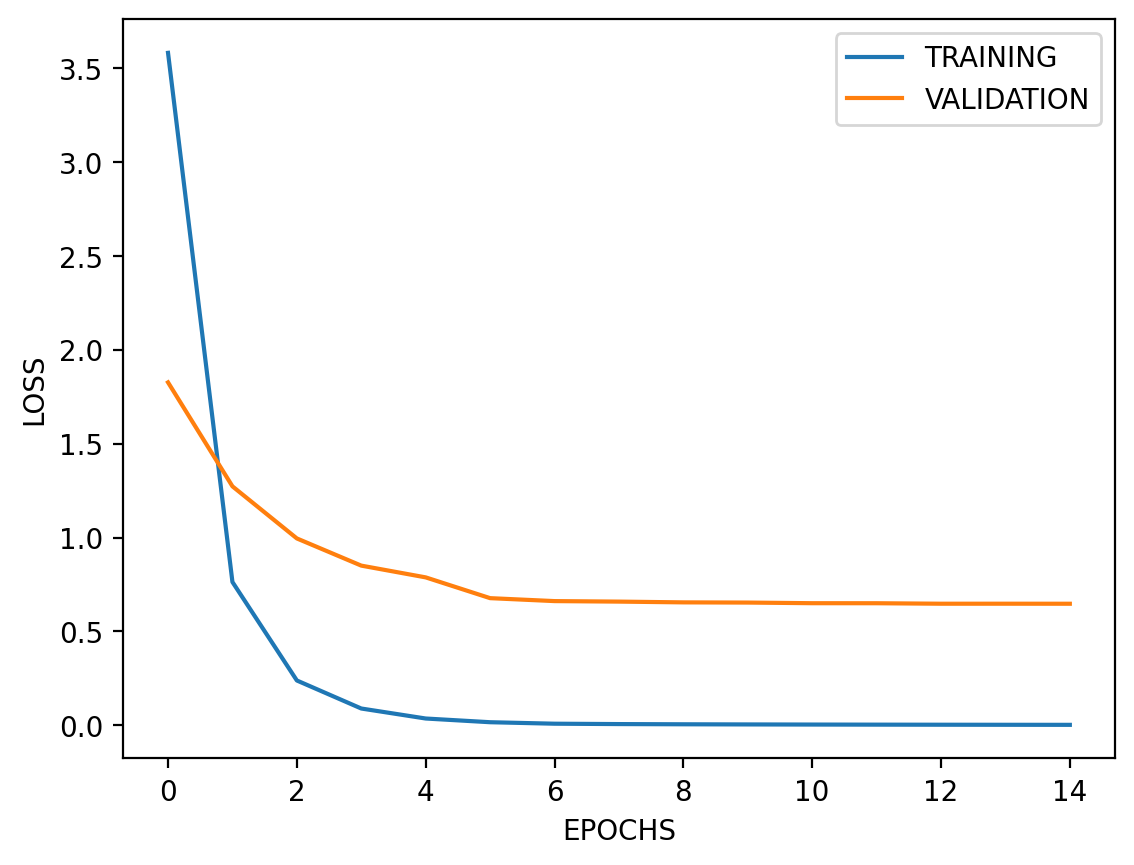

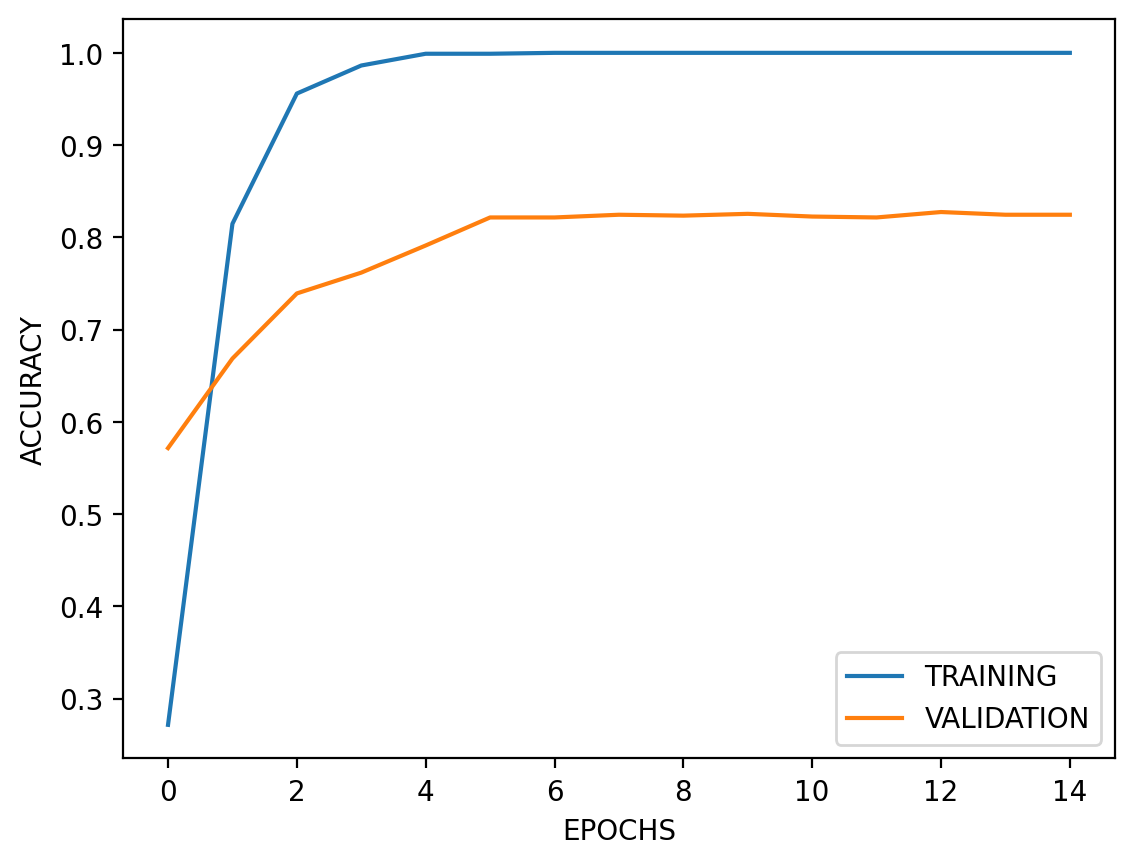

193/193 [==============================] - 110s 567ms/step - loss: 0.8228 - accuracy: 0.7886
test accuracy is: 0.788583517074585


In [20]:
# TODO: Build and train your network.
#URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" # copied from pretrained notebook

#feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

#feature_extractor.trainable = False # Parameter of the networks are frozen

model3 = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(2048, activation = 'relu'),
        tf.keras.layers.Dense(number_of_classes, activation = 'softmax') # classifier with 2 layers in output
])

model3.summary()

model3.compile(optimizer='adam', #copied from last chapter
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 15

history = model3.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

plt.figure()
plt.plot(range(EPOCHS), history.history['loss'], label="TRAINING")
plt.plot(range(EPOCHS), history.history['val_loss'], label="VALIDATION")
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(EPOCHS), history.history['accuracy'], label="TRAINING")
plt.plot(range(EPOCHS), history.history['val_accuracy'], label="VALIDATION")
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.legend()
plt.show()

testloss, testaccuracy = model3.evaluate(testing_batches)
print('test accuracy is: {}'.format(testaccuracy)) 

different_model_accuracy.append(testaccuracy)

# Fourth attempt: Neuronal Network with 2 hidden  and 1 output dens layers -> Model ID 4 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_5 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_7 (Dense)             (None, 102)               104550    
                                                                 
Total params: 4723878 (18.02 MB)
Trainable params: 2465894 (9.41 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Epoch 1/15
32/32 [==============================] - 45s 1s/step - loss: 3.8193 - accuracy: 0.2137 - val_loss: 2.0412 - val_accuracy: 0.5186
Epo

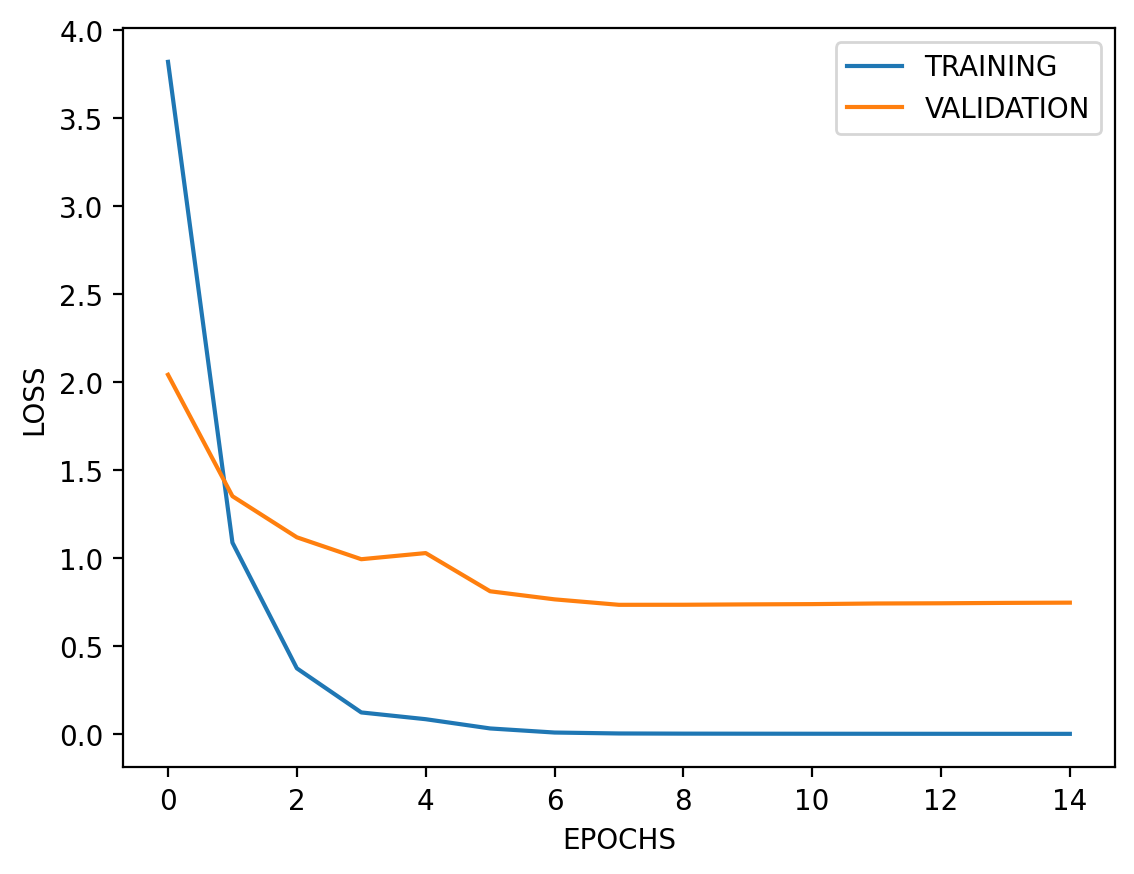

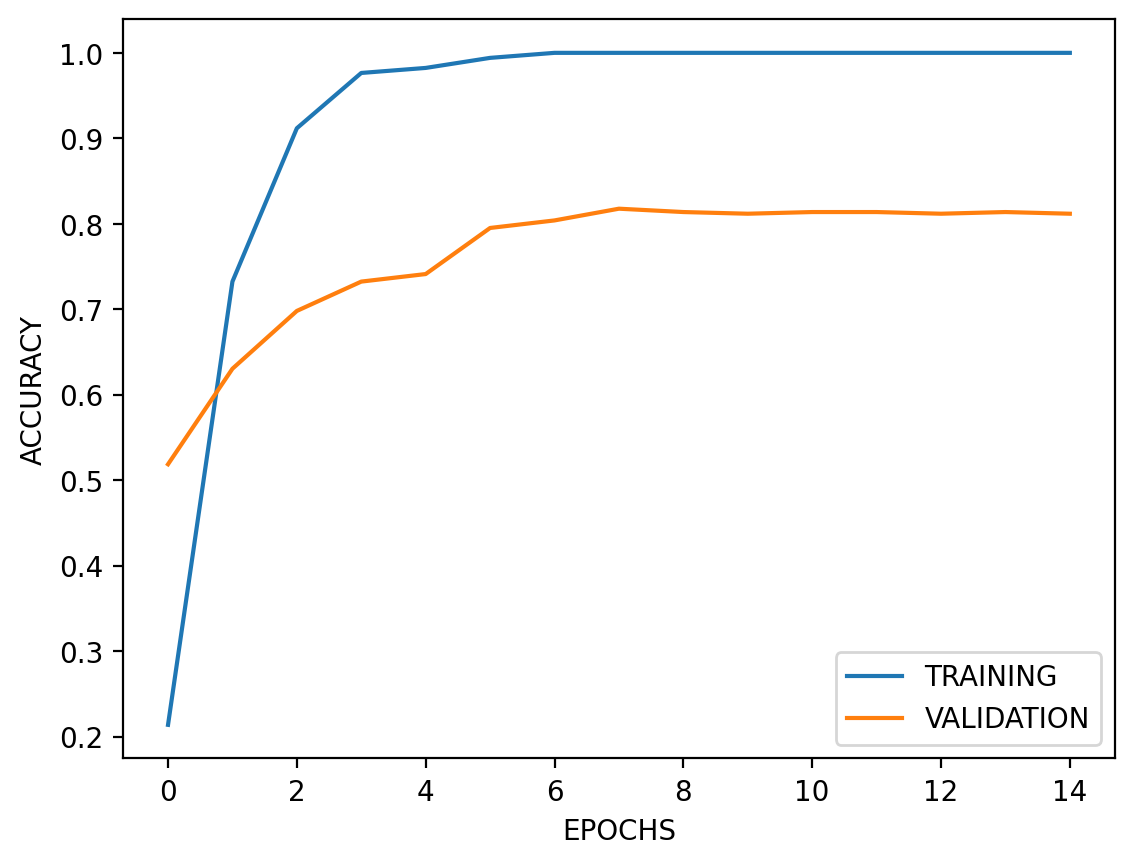

193/193 [==============================] - 128s 661ms/step - loss: 0.9516 - accuracy: 0.7707
test accuracy is: 0.7706944346427917


In [21]:
# TODO: Build and train your network.
#URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" # copied from pretrained notebook

#feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

#feature_extractor.trainable = False # Parameter of the networks are frozen

model4 = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(1024, activation = 'relu'),
        tf.keras.layers.Dense(1024, activation = 'relu'),
        tf.keras.layers.Dense(number_of_classes, activation = 'softmax') # classifier with 2 layers in output
])

model4.summary()

model4.compile(optimizer='adam', #copied from last chapter
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 15

history = model4.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

plt.figure()
plt.plot(range(EPOCHS), history.history['loss'], label="TRAINING")
plt.plot(range(EPOCHS), history.history['val_loss'], label="VALIDATION")
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(EPOCHS), history.history['accuracy'], label="TRAINING")
plt.plot(range(EPOCHS), history.history['val_accuracy'], label="VALIDATION")
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.legend()
plt.show()

testloss, testaccuracy = model4.evaluate(testing_batches)
print('test accuracy is: {}'.format(testaccuracy)) 

different_model_accuracy.append(testaccuracy)

In [22]:
best_model_id = np.argmax(different_model_accuracy) + 1

In [23]:
best_model_id

3

## I save the model with the highest accuracy. 

In [24]:
# TODO: Save your trained model as a Keras model.


saved_keras_modeL_PATH = 'model{}.h5'.format(best_model_id) # Only save the model with the highest accuracy
command_save_model = 'model{}.save(saved_keras_modeL_PATH)'.format(best_model_id)
eval(command_save_model)


In [25]:
# TODO: Load the Keras model
load_keras_modeL_PATH = 'model{}.h5'.format(3) # The best model was with the ID 3

model_load= tf.keras.models.load_model(load_keras_modeL_PATH, custom_objects={'KerasLayer':hub.KerasLayer})
model_load.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_3 (Dense)             (None, 2048)              2623488   
                                                                 
 dense_4 (Dense)             (None, 102)               208998    
                                                                 
Total params: 5090470 (19.42 MB)
Trainable params: 2832486 (10.81 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [26]:
# TODO: Create the process_image function
image_size = 224
def process_image(image): # like above 
    image_size = 224
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255 
    image = image.numpy()
    return image

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

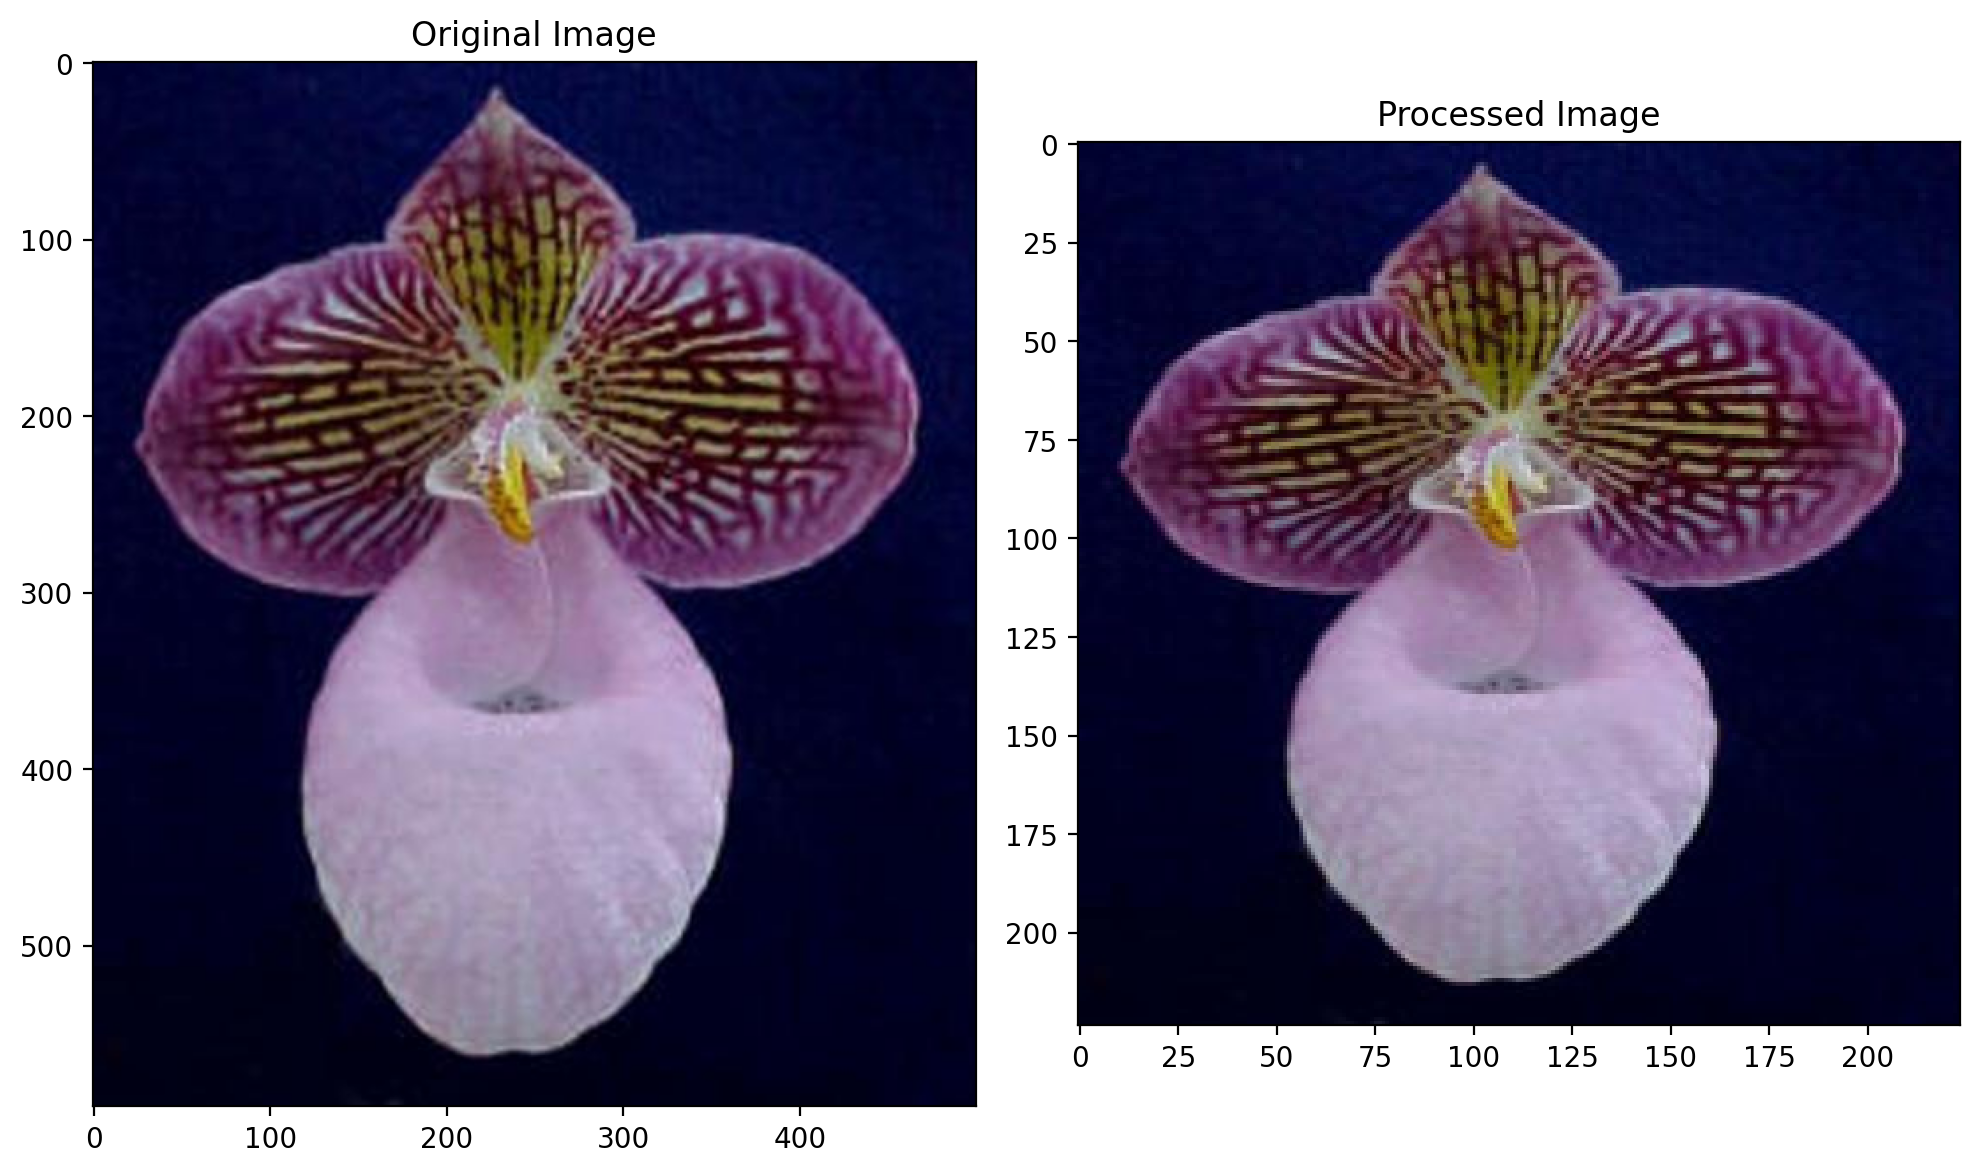

In [27]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [28]:
# TODO: Create the predict function
def predict(image_path, model_load, top_k=5):
    image = Image.open(image_path) # open image
    image = np.asarray(image) # to numpy array
    image = process_image(image)# to 224 pixel and every pixel beteween 0 to 1
    image = np.expand_dims(image, axis=0) # with batch size
    predictions = model_load.predict(image)
    probs, classes = tf.math.top_k(predictions,k=top_k)
    probs, classes = probs.numpy(), classes.numpy()
    image = image.squeeze() # delete batch size
    return image, probs[0], classes[0] # only [] not [[]]



In [29]:
image_path = './test_images/orange_dahlia.jpg'
image, probs, classes = predict(image_path, model_load)
print('{}{}'.format(probs, classes))


1/1 [==============================] - 1s 953ms/step
[0.4793205  0.43448794 0.02342812 0.01672942 0.01140904][ 4 58 99 70 65]


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [30]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [31]:
# TODO: Plot the input image along with the top 5 classes
def plot_image(image_path, model_load, top_k=5):
    image, probs, classes = predict(image_path, model_load, top_k)
    names = []
    for name_nr in classes:
        names.append(class_names[str(name_nr)])
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2) # from the notbook introduction to tensorflow 2
    ax1.imshow(image, cmap = plt.cm.binary)
    ax1.axis('off')
    ax2.barh(np.arange(top_k), probs *100)
    ax2.set_aspect(20)
    ax2.set_yticklabels(names)
    ax2.set_title('Class Probability in %')
    ax2.set_xlim(0, 105)
    plt.tight_layout()

1/1 [==============================] - 0s 51ms/step


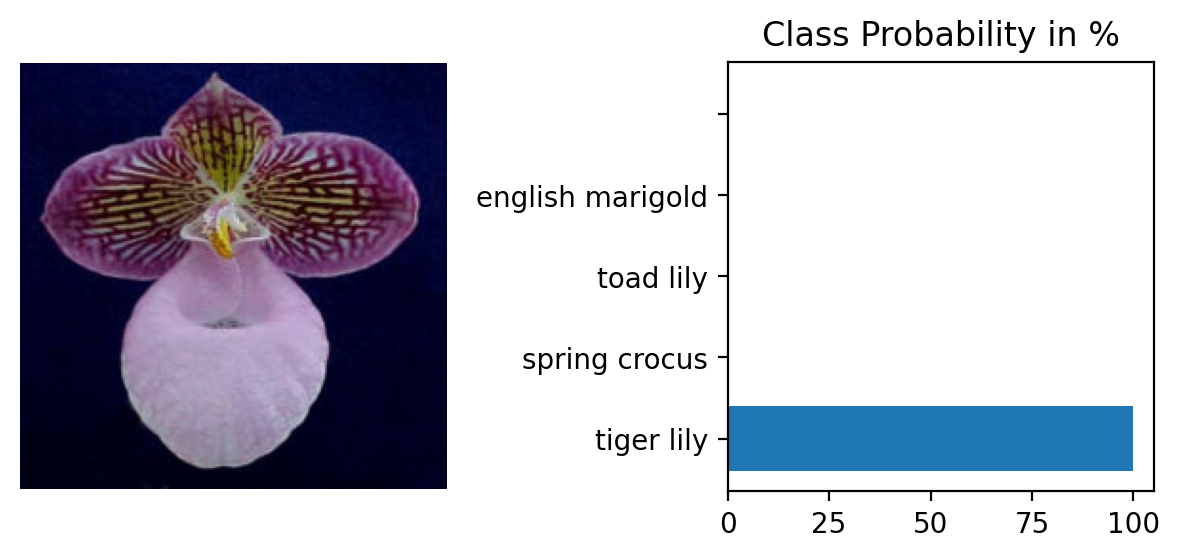

In [32]:

image_path = './test_images/hard-leaved_pocket_orchid.jpg'

plot_image(image_path, model_load)

In [33]:
# Error -> We need to append someting at names[0], because namnes[0] is not displayed. 

In [34]:
# TODO: Plot the input image along with the top 5 classes
def plot_image(image_path, model_load, top_k=5):
    image, probs, classes = predict(image_path, model_load, top_k)
    names = []
    names.append('Index 0')
    for name_nr in classes:
        names.append(class_names[str(name_nr)])
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2) # from the notbook introduction to tensorflow 2
    ax1.imshow(image, cmap = plt.cm.binary)
    ax1.axis('off')
    ax2.barh(np.arange(top_k), probs *100)
    ax2.set_aspect(20)
    ax2.set_yticklabels(names)
    ax2.set_title('Class Probability in %')
    ax2.set_xlim(0, 105)
    plt.tight_layout()

1/1 [==============================] - 0s 54ms/step


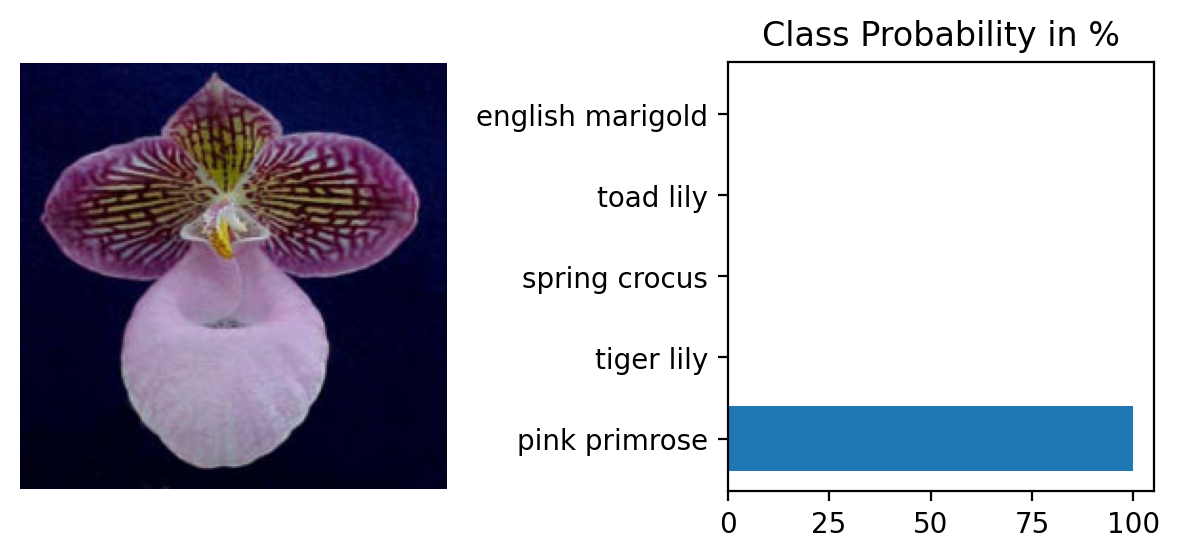

In [35]:
image_path = './test_images/hard-leaved_pocket_orchid.jpg'
plot_image(image_path, model_load)

In [36]:
# Now it works- Print the other images


1/1 [==============================] - 0s 49ms/step


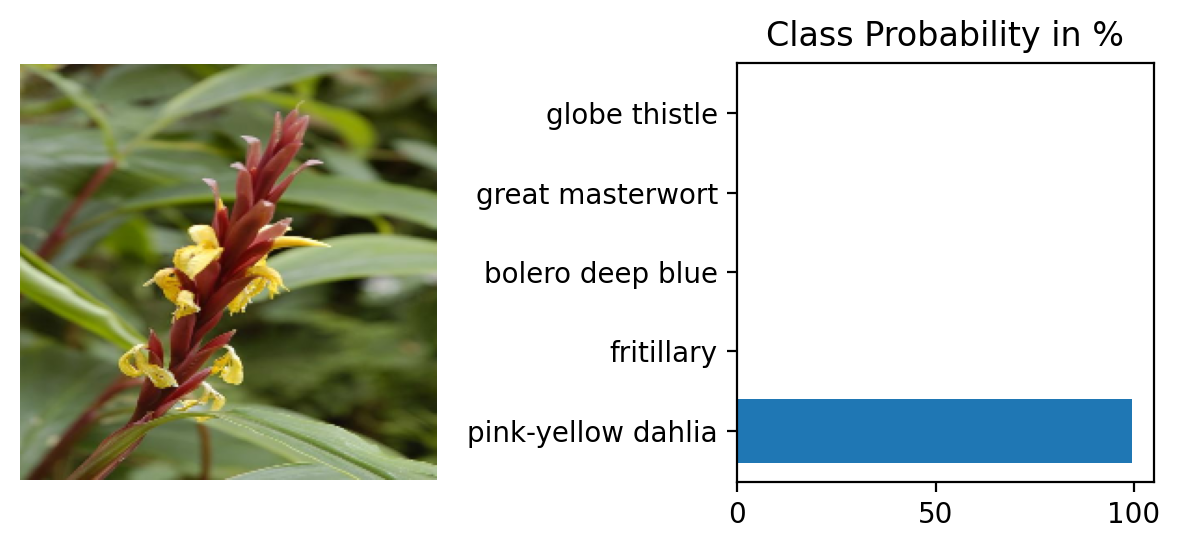

In [37]:
image_path = './test_images/cautleya_spicata.jpg'
plot_image(image_path, model_load)

1/1 [==============================] - 0s 45ms/step


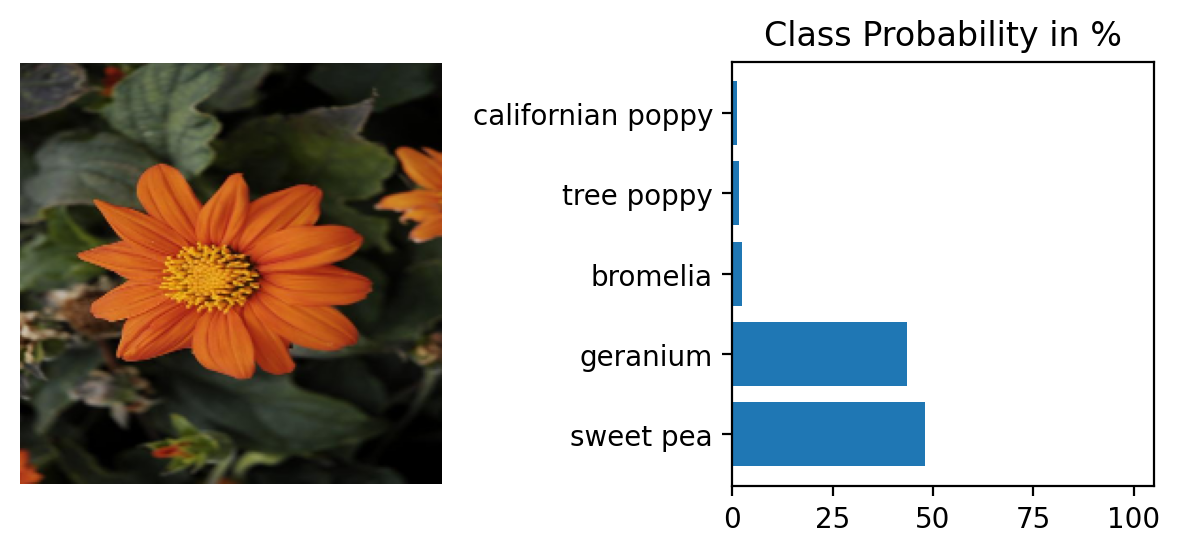

In [38]:
image_path = './test_images/orange_dahlia.jpg'
plot_image(image_path, model_load)

1/1 [==============================] - 0s 47ms/step


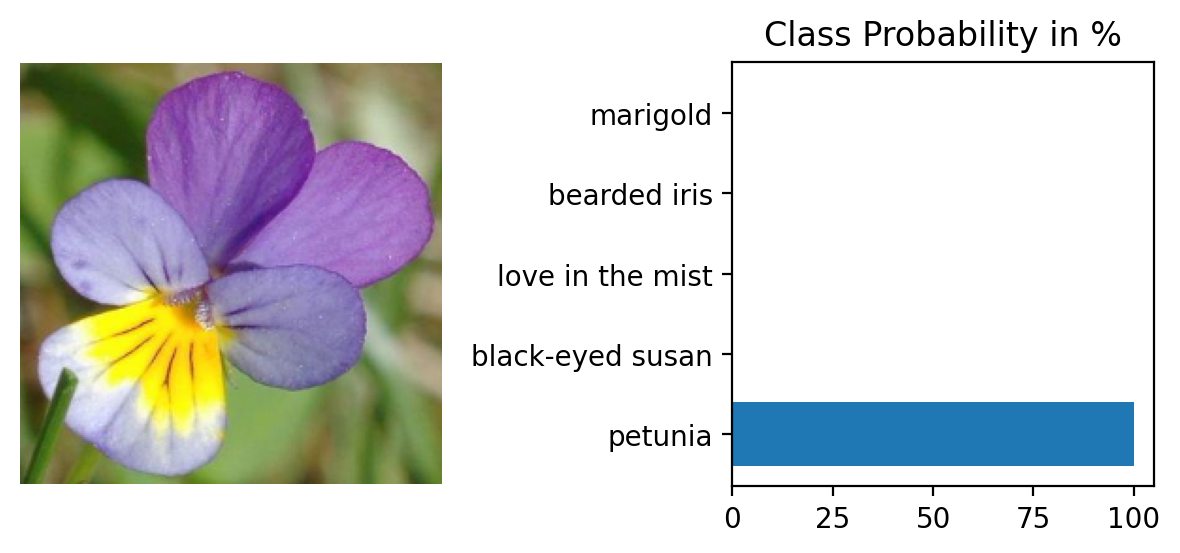

In [39]:
image_path = './test_images/wild_pansy.jpg'
plot_image(image_path, model_load)